In [1]:
%%capture
%run 03_Model_RNN_BNN.ipynb

In [2]:
BATCH_SIZE = 10

# Input pipeline

In [3]:
# prepare data generators using tf.data
train_dataset = (
    tf.data.Dataset.from_tensor_slices((z_train, mu_train))
    #.shuffle(TRAIN_LENGTH, reshuffle_each_iteration=True)
    .batch(BATCH_SIZE, drop_remainder=False)
);

#test_dataset = tf.data.Dataset.from_tensor_slices((z_test,mu_test)).batch(BATCH_SIZE);
val_dataset = (
    tf.data.Dataset.from_tensor_slices((z_val,mu_val))
    .batch(BATCH_SIZE, drop_remainder=False)
);

# Train

In [4]:
model = my_model(0.)

In [5]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(1e-3), 
    loss = tf.keras.losses.MeanSquaredError(), 
    metrics = tf.keras.metrics.RootMeanSquaredError())

In [6]:
# Create a callback that saves the model's weights
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(out_dir,'cp.ckpt'), 
    monitor='val_loss', 
    save_weights_only=True, 
    verbose=1, 
    save_best_only=True
    )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=10, verbose=1,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=1e-10
)

early_stopping = [
    tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=0,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=5,
        verbose=1
    )
]
epochs = 1000
model_history = model.fit(train_dataset,
                          epochs = epochs,
                          validation_data = val_dataset,
                          callbacks = [checkpoint, early_stopping]
                          )

Epoch 1/1000
26/31 [========================>.....] - ETA: 0s - loss: 0.8926 - root_mean_squared_error: 0.9448
Epoch 1: val_loss improved from inf to 0.90515, saving model to ../out/quasar/lstm\cp.ckpt
31/31 [==============================] - 7s 70ms/step - loss: 0.8613 - root_mean_squared_error: 0.9280 - val_loss: 0.9052 - val_root_mean_squared_error: 0.9514
Epoch 2/1000
25/31 [=======================>......] - ETA: 0s - loss: 0.8169 - root_mean_squared_error: 0.9038
Epoch 2: val_loss improved from 0.90515 to 0.79867, saving model to ../out/quasar/lstm\cp.ckpt
31/31 [==============================] - 1s 24ms/step - loss: 0.7715 - root_mean_squared_error: 0.8784 - val_loss: 0.7987 - val_root_mean_squared_error: 0.8937
Epoch 3/1000
27/31 [=========================>....] - ETA: 0s - loss: 0.7237 - root_mean_squared_error: 0.8507
Epoch 3: val_loss improved from 0.79867 to 0.75120, saving model to ../out/quasar/lstm\cp.ckpt
31/31 [==============================] - 1s 19ms/step - loss: 0.69

In [23]:
# model.save_weights(os.path.join(out_dir, 'cp.ckpt'))

In [7]:
# load the best weights
model.load_weights(os.path.join(out_dir, 'cp.ckpt'))

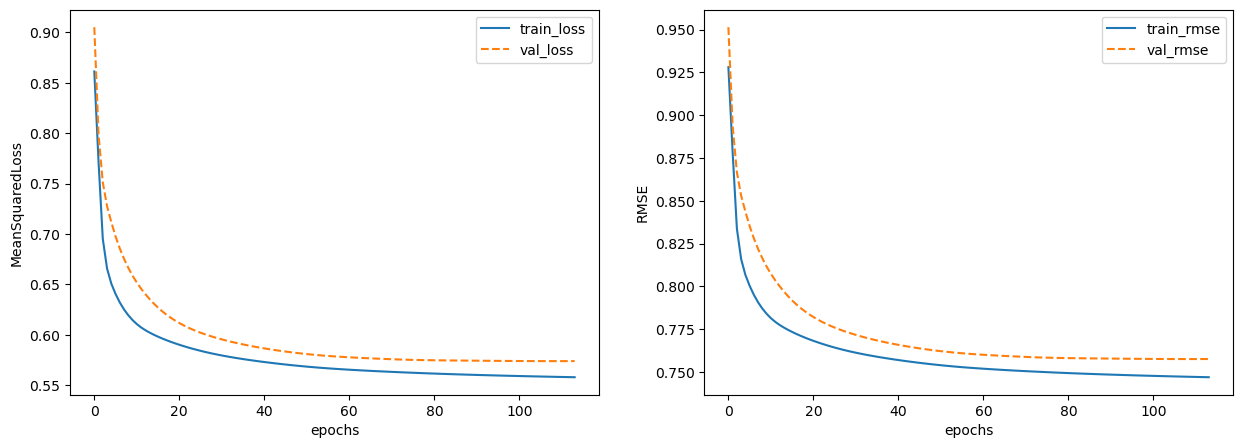

In [8]:
# plot epoch vs loss, epoch vs RMSE
plt.figure(figsize=(15,5))

epochs = len(model_history.history['loss'])

plt.subplot(1,2,1)
plt.plot(np.arange(0,epochs,1), model_history.history['loss'], '-', label='train_loss')
plt.plot(np.arange(0,epochs,1), model_history.history['val_loss'], '--', label='val_loss', )
plt.xlabel('epochs')
plt.ylabel('MeanSquaredLoss')
#plt.title('epoch vs loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.arange(0,epochs,1), model_history.history['root_mean_squared_error'], '-', label='train_rmse')
plt.plot(np.arange(0,epochs,1), model_history.history['val_root_mean_squared_error'], '--', label='val_rmse')
plt.xlabel('epochs')
plt.ylabel('RMSE')
#plt.title('epoch vs RMSE')
plt.legend()
plt.savefig(os.path.join(out_dir,'05_epoch_vs_loss.pdf'))
plt.show()

In [26]:
#model.evaluate(test_dataset)

# Sample Reconstruction

In [9]:
# Reconstruct 
z_reconstruct = np.linspace(0,8.5,212)[::-1]
z_reconstruct = np.expand_dims(strided_app(z_reconstruct, window_size, 1), axis=-1)

In [10]:
mu_reconstruct = model.predict(z_reconstruct, batch_size=BATCH_SIZE)
mu_reconstruct = mu_scaler.inverse_transform(mu_reconstruct.reshape(-1,4))

21/21 [==============================] - 1s 4ms/step


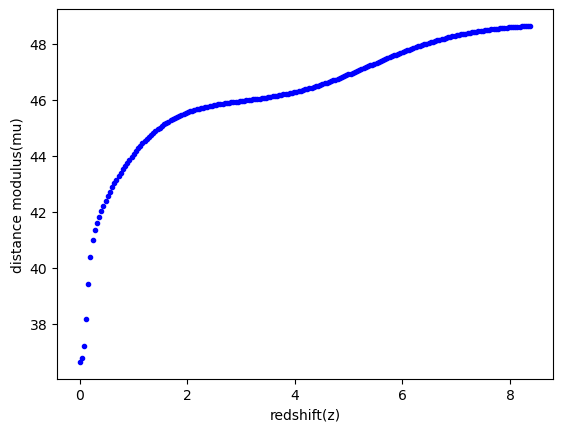

In [11]:
# plot reconstructed z vs mu
plt.plot(z_reconstruct[:,-1].flatten(), mu_reconstruct[:,-1].flatten(), '.',color='b');
plt.xlabel('redshift(z)')
plt.ylabel('distance modulus(mu)')
#plt.title('Distance modulus vs redshift')
plt.savefig(os.path.join(out_dir,'06_sample_reconstruction.pdf'))
plt.show()

# Sample Reconstruction with uncertainity

In [30]:
model_u = model_uncertainity()

In [31]:
model_u.load_weights(os.path.join(out_dir,'cp.ckpt'))

In [32]:
model_u.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=tf.keras.losses.MeanSquaredError(), metrics=tf.keras.metrics.RootMeanSquaredError())

In [33]:
mu_reconstruct_uncertainity = []
n = 1000
for i in range(n):
    y_pred = model_u.predict(z_reconstruct, batch_size=500)[:,-1].flatten()
    y_pred = mu_scaler.inverse_transform(y_pred.reshape(-1,1))
    mu_reconstruct_uncertainity.append(y_pred)

In [34]:
mu_reconstruct_uncertainity = np.array(mu_reconstruct_uncertainity)
mean = np.mean(mu_reconstruct_uncertainity, axis=0).flatten()
std_dev = np.std(mu_reconstruct_uncertainity, axis=0).flatten()

In [35]:
# z_reconstruct = z_scaler.inverse_transform(z_reconstruct[:,-1]) 

/tmp/ipykernel_178825/344823818.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".r" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(df_SNe['zCMB'], df_SNe['MU'], yerr=df_SNe['MUERR'], fmt='.r', label=dataset+' Sample', color='r');


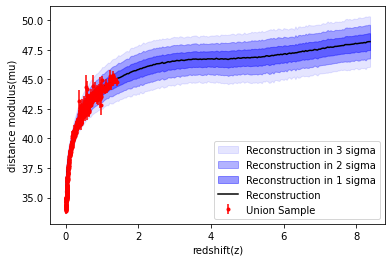

In [36]:
#plt.figure(figsize=(10,7))
plt.fill_between(
    z_reconstruct[:,-1].flatten(), 
    mean-3*std_dev, mean+3*std_dev,
    label='Reconstruction in 3 sigma',color='b', alpha=0.1)
plt.fill_between(
    z_reconstruct[:,-1].flatten(), 
    mean-2*std_dev, mean+2*std_dev,
    label='Reconstruction in 2 sigma',color='b', alpha=0.3)
plt.fill_between(
    z_reconstruct[:,-1].flatten(), 
    mean-1*std_dev, mean+1*std_dev,
    label='Reconstruction in 1 sigma', color='b', alpha=0.4)

plt.plot(z_reconstruct[:,-1].flatten(), mean, label='Reconstruction', color='k')
plt.errorbar(df_SNe['zCMB'], df_SNe['MU'], yerr=df_SNe['MUERR'], fmt='.r', label=dataset+' Sample', color='r');
plt.xlabel('redshift(z)')
plt.ylabel('distance modulus(mu)')
#plt.title('The reconstruction of distance moduli from '+dataset+' data ')
plt.legend()
plt.savefig(os.path.join(out_dir,'07_sample_reconstruction_with_uncertainity.pdf'))
plt.show()